# Introduction to Machine Learning (CSCI-UA.473)

## Homework 4: Long-Short Term Memory Networks and Ensemble of Neural Network Models
### Due: November 18th, 2021 at 11:59PM


### Name: Jerry Jia
### Email: tj1043

This homework has two parts. In the first part you will implement the long-short term memory networks and train them on a specific sequence modeling task. In the second part you will build an ensemble of neural networks for a specific problem and conduct some error analysis.

## Question P1: Long-Short Term Memory Networks (35 Points Total)

In this problem you will implement a long-short term memory (LSTM) models from scratch and train them for the language modeling task. You will also do some error analysis and ablation studies on the learnt model. 

**At no point are you allowed to use PyTorch's nn.LSTM function in the code. Remember the goal of this assignment is to build the LSTM from scratch.**

### Define some helper functions to handle the text data (do nothing here)

In [1]:
import torch
import os

class Dictionary(object):
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0
    
    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1
    
    def __len__(self):
        return len(self.word2idx)


class Corpus(object):
    def __init__(self):
        self.dictionary = Dictionary()

    def get_data(self, path, batch_size=20):
        # Add words to the dictionary
        with open(path, 'r') as f:
            tokens = 0
            for line in f:
                words = line.split() + ['<eos>']
                tokens += len(words)
                for word in words: 
                    self.dictionary.add_word(word)  
        
        # Tokenize the file content
        ids = torch.LongTensor(tokens)
        token = 0
        with open(path, 'r') as f:
            for line in f:
                words = line.split() + ['<eos>']
                for word in words:
                    ids[token] = self.dictionary.word2idx[word]
                    token += 1
        num_batches = ids.size(0) // batch_size
        ids = ids[:num_batches*batch_size]
        return ids.view(batch_size, -1)
 

### Define some hyper-parameters of the model (do nothing here.. yet)
We will now define some hyper-parameters to be used with the model. Later on in the assignment you will be experimenting with some of these. 

In [2]:
import torch.nn as nn
import numpy as np
from torch.nn.utils import clip_grad_norm_

# Device configuration
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

# Hyper-parameters
embed_size = 32         # size of the input feature vector representing each word
hidden_size = 32        # number of hidden units in the LSTM cell
num_epochs = 1          # number of epochs for which you will train your model    
num_samples = 200       # number of words to be sampled
batch_size = 20         # the size of your mini-batch
seq_length = 30         # the size of the BPTT window
learning_rate = 0.002   # learning rate of the model

device

device(type='cpu')

### Load the sequential data (do nothing here)

We will use the Penn Tree Bank dataset for the purpose of this exercise. You need to download by running the command `wget https://data.deepai.org/ptbdataset.zip`, unzip it, and store it in the directory `./data/ptb`. We will only use the files `ptb.train.txt` and `ptb.test.txt`. 

In [3]:
# Load the dataset 
corpus = Corpus()
ids = corpus.get_data('./data/ptb/ptb.train.txt', batch_size)
vocab_size = len(corpus.dictionary)
num_batches = ids.size(1) // seq_length

test_corpus = Corpus()
test_ids = test_corpus.get_data('./data/ptb/ptb.test.txt', batch_size)
test_vocab_size =  len(test_corpus.dictionary)
test_num_batches = test_ids.size(1) // seq_length

print(num_batches)
print(test_num_batches)

1549
137


### Implement the Long-Short Term Memory (LSTM) unit (20 Points)

You will be implementing a single unit of the LSTM and also write its forward propagation algorithm. The single LSTM unit performs the following operations: 

$$
\begin{align}
i_t & = \sigma (W_{ii} x_t + b_{ii} + W_{hi} h_{t-1} + b_{hi}) \\
f_t & = \sigma (W_{if} x_t + b_{if} + W_{hf} h_{t-1} + b_{hf}) \\
g_t & = \sigma (W_{ig} x_t + b_{ig} + W_{hg} h_{t-1} + b_{hg}) \\
o_t & = \sigma (W_{io} x_t + b_{io} + W_{ho} h_{t-1} + b_{ho}) \\
c_t & = f_t \odot c_{t-1} + i_t \odot g_t \\
h_t & = o_t \odot \tanh(c_t)
\end{align}
$$

where $h_t$ is the hidden state at time $t$, $c_t$ is called the memory cell state at time $t$, $x_t$ is the input at time $t$, $h_{t-1}$ is the hidden state of the layer at time $t-1$ or the initial hidden state at time $0$, and $i_t$, $f_t$, $g_t$, $o_t$, are the input, forget, cell, and output gates, respectively. $\sigma$ is the sigmoid function, and $\odot$ is the Hadamard (element-wise) product of two vectors. Finally $\{W_{ii}, b_{ii}, W_{hi}, b_{hi}\}$, $\{W_{if}, b_{if}, W_{hf}, b_{hf}\}$, $\{W_{ig}, b_{ig}, W_{hg}, b_{hg}\}$, and $\{W_{io}, b_{io}, W_{ho}, b_{ho}\}$ are the learnable weights and biases for computing the input, forget, cell, and output gates respectively.

At each time step the LSTM takes as input the previous hidden state, the previous memory cell state and the embedding (features) associated with the current word and generates the new hidden states and the prediction of the next word. 

**Hint: Note that the recurrsion is around two variables, namely, $h_t$ and $c_t$. Hence you will need to keep track of two previous hidden states.**

In [4]:
def s(x):
    o = list(x.size())
    print(o)
    # print(o[0] if len(o) == 1 else ', '.join(o))


In [16]:
# myLSTM based language model
sig = torch.sigmoid
tanh = torch.tanh
torch.autograd.set_detect_anomaly(True)


class myLSTM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        """
        Input: 
            vocab_size: the number of unique words in your dataset 
            embed_size: the size of the feature vector assiciated with each word
            hidden_size: the size of the hidden state features
        """
        super(myLSTM, self).__init__()
        self.embed = nn.Embedding(
            vocab_size, embed_size
        )  # features associated with the words in your vocabulary

        # rest of your LSTM model code goes here
        combined_size = hidden_size + seq_length

        # print(vocab_size, embed_size, hidden_size)

        self.fi = nn.Linear(seq_length, hidden_size).to(device)
        self.fh = nn.Linear(hidden_size, hidden_size).to(device)
        self.ii = nn.Linear(seq_length, hidden_size).to(device)
        self.ih = nn.Linear(hidden_size, hidden_size).to(device)
        self.gi = nn.Linear(seq_length, hidden_size).to(device)
        self.gh = nn.Linear(hidden_size, hidden_size).to(device)
        self.oi = nn.Linear(seq_length, hidden_size).to(device)
        self.oh = nn.Linear(hidden_size, hidden_size).to(device)

        self.linear = nn.Linear(hidden_size, seq_length).to(device)

    def forward(self, x, states):
        """
        Perform forward propagation over a single unit composed of an LSTM unit followed by a linear layer to 
        generate the input activations for the softmax function. 
    
        Input:
            x: the current input (indices into the vocabulary)
            h: the previous hidden states

        Output:
            out: the output of the unit (which are the input activations of the softmax layer to predict the next word)
            (h, c): the current hidden states composed of the hidden state and the memory cell state
        """
        h_prev, c_prev = states
        # xh = torch.cat((x, h_prev), dim=1)

        f = sig(self.fi(x) + self.fh(h_prev))
        i = sig(self.ii(x) + self.ih(h_prev))
        # i = sig(self.i(xh))
        g = tanh(self.gi(x) + self.gh(h_prev))
        o = sig(self.oi(x) + self.oh(h_prev))

        c = f * c_prev + i * g
        h = o * tanh(c)

        out = self.linear(h)

        # your code goes here
        return out, (h, c)


model = myLSTM(vocab_size, embed_size, hidden_size)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()  # the loss function

# we will use the Adam optimizer for faster and easier convergence
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


?? Use cross entropy loss function from pytorch

### Training loop for the model (7.5 Points)

In [23]:
# Truncated backpropagation
def detach(states):
    return [state.detach() for state in states]


# Train the model
for epoch in range(num_epochs):
    # Set initial hidden and cell states
    states = (torch.zeros(1, batch_size, hidden_size).to(device),
              torch.zeros(1, batch_size, hidden_size).to(device))

    for i in range(0, ids.size(1) - seq_length, seq_length):
        # Get mini-batch inputs and targets
        inputs = ids[:, i:i + seq_length].to(device)
        targets = ids[:, (i + 1):(i + 1) + seq_length].to(device)


        # Forward pass
        # Starting each batch, we detach the hidden state from how it was previously produced.
        # If we didn't, the model would try backpropagating all the way to start of the dataset.
        states = detach(states)

        s(inputs)
        s(targets)
        s(states[0])
        # s(states[1])

        for j, (input,target) in enumerate(zip(inputs, targets)):
            input = input.float().to(device)
            h_prev = states[0][i][j]
            c_prev = states[1][i][j]
            output, (h, c) = model(input, (h_prev, c_prev))
            s(h)
            s(c)
            states[0][i][j] = h
            states[1][i][j] = c
            ## code for backward pass goes here ##
            target = target.argmax(dim=1)
            # print('output:', list(output.size()), '\ntarget:', list(targets.size()))

            loss = criterion(output, target)

            # Clear the gradient buffers of the optimized parameters.
            optimizer.zero_grad()

            # the backward pass over the loss and the model
            loss.backward()

        ## the code for the rest of the forward pass goes here ##

        # Backward pass

        ## code for backward pass goes here ##

        # we clip the gradients to ensure that they remain bounded. This is a hack!
        clip_grad_norm_(model.parameters(), 0.5)

        # Optimize

        ## code for optimization goes here ##

        step = (i + 1) // seq_length
        if step % 100 == 0:
            print(
                'Epoch [{}/{}], Step[{}/{}], Loss: {:.4f}, Perplexity: {:5.2f}'
                .format(epoch + 1, num_epochs, step, num_batches, loss.item(),
                        np.exp(loss.item())))


[20, 30]
[20, 30]
[1, 20, 32]
[32]
[32]


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [ ]:
# Truncated backpropagation
def detach(states):
    # Detach from pytorch computational graph
    return [state.detach() for state in states]

def to_word(x):
    return [corpus.dictionary.idx2word.get(i.item()) for i in x]

# Train the model
for epoch in range(num_epochs):
    model.train()
    # Set initial hidden and cell states
    states = (torch.zeros(1, batch_size, hidden_size).to(device), # h
              torch.zeros(1, batch_size, hidden_size).to(device)) # c
    for i in range(0, ids.size(1) - seq_length, seq_length):
        # Get mini-batch inputs and targets
        inputs = ids[:, i:i+seq_length].to(device)
        print(f'inputs.size = {list(inputs.size())}')
        targets = ids[:, (i+1):(i+1)+seq_length].to(device)
        # Forward pass
        # Starting each batch, we detach the hidden state from how it was previously produced.
        # If we didn't, the model would try backpropagating all the way to start of the dataset.
        states = detach(states)

        ## the code for the rest of the forward pass goes here ##
        # h = states[0][epoch]
        # c = states[1][epoch]
        # print('State: ', s(states[0].size()), s(states[1]))
        # print('State: ', states[0].size(), states[1].size())
        # print('State: ', len(states))
        # print('State: ', states[:][-1, :, :].size())
        # print(f'h = {h.size()}; c = {c.size()}')
        # output, (h, c) = model.forward(inputs, states[:, -1, :])
        # output, (h,c) = model.forward(inputs, (h,c))
        output, (states[0][epoch], states[1][epoch]) = model.forward(
            inputs, (states[0][epoch], states[1][epoch]))
        # states[0][i] = h
        # states[1][i] = c

        ## code for backward pass goes here ##
        targets = targets.argmax(dim=1)
        # print('output:', list(output.size()), '\ntarget:', list(targets.size()))

        loss = criterion(output, targets)

        # Clear the gradient buffers of the optimized parameters.
        optimizer.zero_grad()

        # the backward pass over the loss and the model
        loss.backward()

        # we clip the gradients to ensure that they remain bounded. This is a hack!
        clip_grad_norm_(model.parameters(), 0.5)

        # Optimize

        ## code for optimization goes here ##
        #   the gradient step to update the weights
        optimizer.step()


        step = (i+1) // seq_length
        if step % 100 == 0:
            print ('Epoch [{}/{}], Step[{}/{}], Loss: {:.4f}, Perplexity: {:5.2f}'
                   .format(epoch+1, num_epochs, step, num_batches, loss.item(), np.exp(loss.item())))

inputs.size = [20, 30]


/home/jkker/miniconda3/envs/ml/lib/python3.9/site-packages/torch/autograd/__init__.py:154: UserWarning: Error detected in MulBackward0. Traceback of forward call that caused the error:
  File "/home/jkker/miniconda3/envs/ml/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/jkker/miniconda3/envs/ml/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/jkker/miniconda3/envs/ml/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/jkker/miniconda3/envs/ml/lib/python3.9/site-packages/traitlets/config/application.py", line 845, in launch_instance
    app.start()
  File "/home/jkker/miniconda3/envs/ml/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 667, in start
    self.io_loop.start()
  File "/home/jkker/miniconda3/envs/ml/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [20, 32]], which is output 0 of AsStridedBackward0, is at version 1; expected version 0 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!

### Testing loop for the model (7.5 Points)

In [ ]:
import math

# Test the model
states = (torch.zeros(1, batch_size, hidden_size).to(device),
              torch.zeros(1, batch_size, hidden_size).to(device))
test_loss = 0.
with torch.no_grad():
    for i in range(0, test_ids.size(1) - seq_length, seq_length):
        # Get mini-batch inputs and targets
        inputs = test_ids[:, i:i+seq_length].to(device)
        targets = test_ids[:, (i+1):(i+1)+seq_length].to(device)

        # Forward pass
        states = detach(states)

        ## code for forward pass goes here ##
        output, states = model.forward(inputs, states)
        targets = targets.argmax(dim=1)
        test_loss = criterion(output, targets)

test_loss = test_loss / test_num_batches
print('test loss {:5.2f} | test ppl {:8.2f}'.format(
    test_loss, math.exp(test_loss)))


### Generating text using the trained model

In [ ]:
# Generate texts using trained model
with torch.no_grad():
    with open('sample.txt', 'w') as f:
        # Set intial hidden ane cell states
        state = (torch.zeros(1, hidden_size).to(device),
                 torch.zeros(1, hidden_size).to(device))

        # Select one word id randomly
        prob = torch.ones(vocab_size)
        input = torch.multinomial(prob, num_samples=1).unsqueeze(1).to(device)

        for i in range(num_samples):
            # Forward propagate RNN 
            output, state = model(input, state)

            # Sample a word id
            prob = output.exp()
            word_id = torch.multinomial(prob, num_samples=1).item()

            # Fill input with sampled word id for the next time step
            input.fill_(word_id)

            # File write
            word = corpus.dictionary.idx2word[word_id]
            word = '\n' if word == '<eos>' else word + ' '
            f.write(word)

            if (i+1) % 100 == 0:
                print('Sampled [{}/{}] words and save to {}'.format(i+1, num_samples, 'sample.txt'))

## Question P2: Ensemble of Neural Networks (35 Points Total)
In this part of the assignment, you will train an ensemble of neural networks for classifying hand written digits in the MNIST dataset. You will take the code provided in the following cell and extend it to build an ensemble of single hidden layer MLP as per the specifications provided in the questions below. 

For the data, you need to download the MNIST dataset from ``http://yann.lecun.com/exdb/mnist/`` and place the files in the directory ``./data/MNIST``. 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load the MNIST dataset
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data/MNIST', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data/MNIST', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

In [ ]:
# define the multi-layer perceptron model
class FC2Layer(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, output_size),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)

# define the training loop
def train(epoch, model):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        # forward pass through the model
        output = model(data)
        # forward pass through the cross-entropy loss function
        loss = F.nll_loss(output, target)
        # backward pass through the cross-entropy loss function and the model
        loss.backward()

        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


# define the testing loop
def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # data, target = data.to(device), target.to(device)

        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        print(torch.flatten(pred))
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list = []
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))


# function to count number of parameters
def get_n_params(model):
    np = 0
    for p in list(model.parameters()):
        np += p.nelement()
    return np


In [ ]:
# build the model and execute the training and testing
# initialize some hyper-paramters
n_hidden = 4  # number of hidden units
learning_rate = 0.01
moment = 0.5
nepochs = 1

# build the actual model
model_fnn = FC2Layer(input_size, n_hidden, output_size)
# model_fnn.to(device)
# initialize the optimizer
optimizer = optim.SGD(model_fnn.parameters(),
                      lr=learning_rate,
                      momentum=moment)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

# train the model for one epoch
for epoch in range(0, nepochs):
    train(epoch, model_fnn)
    test(model_fnn)

### Question P2.a: Ensemble of networks of same size but initialized with a different seed (20 Points)
Extend the above code to create an ensemble of `k` single hidden layer MLP models, each initialized with a different random seed. Train each model inside the ensemble for exactly `1` epoch and report the performance of the individual models and the ensemble model on the test set. For the purpose of ensembling, you can take a majority vote of the model outputs. 

At a high level you need to perform the following tasks:
1. Initialize `k` models with different random seed (for some value of k): (**5 points**)
2. Extend the train() function to train individual models inside the ensemble: (**5 points**)
3. Extend the test() function to estimate the accuracy of the individual models and the ensemble model: (**5 points**)
4. Repeat the above process with different values of `k`. For this exercise use $k = \{1, 2, 4, 8, 16, 32 \}$, and plot a graph with `k` on the x-axis and ensemble model performance on the y-axis. (**5 points**)

In [ ]:
class EnsembleMLP(nn.Module):
    def __init__(self,
                 k,
                 input_size,
                 n_hidden,
                 output_size,
                 learning_rate=learning_rate,
                 moment=moment,
                 verbose=True,
                 manual_seed=None):
        self.verbose = verbose
        super(EnsembleMLP, self).__init__()
        self.input_size = input_size
        self.k = k
        self.models = nn.ModuleList()
        self.optimizers = []
        if manual_seed is not None:
            torch.manual_seed(manual_seed)
        for i in range(k):
            if manual_seed is None: torch.manual_seed(i)
            model = FC2Layer(input_size, n_hidden, output_size)
            optimizer = optim.SGD(model.parameters(),
                                  lr=learning_rate,
                                  momentum=moment)
            self.models.append(model)
            self.optimizers.append(optimizer)

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return [model.network(x) for model in self.models]

    # define the training loop
    def train(self, epoch, loader=train_loader):
        for i, (model,
                optimizer) in enumerate(zip(self.models, self.optimizers)):
            model.train()

            for batch_idx, (data, target) in enumerate(loader):

                optimizer.zero_grad()
                # forward pass through the model
                output = model(data)
                # forward pass through the cross-entropy loss function
                loss = F.nll_loss(output, target)
                # backward pass through the cross-entropy loss function and the model
                loss.backward()

                optimizer.step()
                if batch_idx % 200 == 0 and self.verbose:
                    print('Model {} Epoch {}: [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}'.
                          format(i, epoch, batch_idx * len(data),
                                 len(loader.dataset),
                                 100. * batch_idx / (len(loader) - 1),
                                 loss.item()))
                
                if batch_idx == len(loader)-1:
                    print('Model {} Epoch {} Final Train Loss: {:.6f}'.
                        format(i, epoch, loss.item()))

    def eval(self):
        for model in self.models:
            model.eval()

    def test_one(self, model, loader=test_loader):
        model.eval()
        test_loss = 0
        correct = 0
        pred_list = []
        for data, target in loader:
            output = model(data)
            test_loss += F.nll_loss(
                output, target, reduction='sum').item()  # sum up batch loss
            pred = output.data.max(
                1, keepdim=True)[1]  # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()
            pred_list.append(pred)

        test_loss /= len(loader.dataset)
        accuracy = 100. * correct / len(loader.dataset)
        print(
            '\nk={} Ensemble Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
            .format(self.k, test_loss, correct, len(loader.dataset),
                    accuracy))
        return test_loss, accuracy

    def test(self):
        if self.k == 1:
            return self.test_one(self.models[0])
        self.eval()
        test_loss = torch.zeros(self.k)
        correct = torch.zeros(self.k)
        ensemble_test_loss = 0
        ensemble_correct = 0
        test_size = len(test_loader.dataset)
        for data, target in test_loader:
            preds = []
            for m, model in enumerate(self.models):
                output = model(data)
                test_loss[m] += F.nll_loss(
                    output, target,
                    reduction='sum').item()  # sum up batch loss
                pred = output.data.max(
                    1, keepdim=True)[1]  # get the index of the max log-probability
                preds.append(pred)

                correct[m] += pred.eq(
                    target.data.view_as(pred)).cpu().sum().item()

            ensemble_pred = torch.mode(torch.stack(preds), 0).values
            # print(ensemble_pred)
            ensemble_correct += ensemble_pred.eq(target.data.view_as(ensemble_pred)).cpu().sum().item()

        for m, model in enumerate(self.models):
            test_loss[m] /= test_size
            accuracy = 100. * correct[m] / test_size
            print(
                'Model {} Test Loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'
                .format(m, test_loss[m].item(), correct[m].item(), test_size,
                        accuracy.item()))

        ensemble_test_loss = test_loss.mean()
        ensemble_accuracy = 100. * ensemble_correct / test_size
        print('\nk={} Ensemble Average Loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.
              format(self.k, ensemble_test_loss, ensemble_correct,
                     test_size, ensemble_accuracy))
        return ensemble_test_loss, ensemble_accuracy


In [ ]:
# initialize some hyper-paramters
n_hidden = 4  # number of hidden units
learning_rate = 0.01
moment = 0.5
nepochs = 1

# build the actual model
model_ensemble = EnsembleMLP(2, input_size, n_hidden, output_size)
# model_ensemble.to(device)

# train the model for one epoch
for epoch in range(nepochs):
    print(f'======== TRAIN EPOCH {epoch} ========')
    model_ensemble.train(epoch)
    torch.save(model_ensemble.state_dict(), './model_ensemble')

    print(f'\n======== TEST EPOCH {epoch} ========')
    model_ensemble.test()

======== TRAIN EPOCH 0 ========
Model 0 Epoch 0: [0/60000 (0%)]	Loss: 2.333221
Model 0 Epoch 0: [6400/60000 (11%)]	Loss: 2.032293
Model 0 Epoch 0: [12800/60000 (21%)]	Loss: 1.932000
Model 0 Epoch 0: [19200/60000 (32%)]	Loss: 1.703176
Model 0 Epoch 0: [25600/60000 (43%)]	Loss: 1.595040
Model 0 Epoch 0: [32000/60000 (53%)]	Loss: 1.718608
Model 0 Epoch 0: [38400/60000 (64%)]	Loss: 1.470350
Model 0 Epoch 0: [44800/60000 (75%)]	Loss: 1.375910
Model 0 Epoch 0: [51200/60000 (85%)]	Loss: 1.602173
Model 0 Epoch 0: [57600/60000 (96%)]	Loss: 1.386774
Model 1 Epoch 0: [0/60000 (0%)]	Loss: 2.418856
Model 1 Epoch 0: [6400/60000 (11%)]	Loss: 2.182961
Model 1 Epoch 0: [12800/60000 (21%)]	Loss: 1.636517
Model 1 Epoch 0: [19200/60000 (32%)]	Loss: 1.557359
Model 1 Epoch 0: [25600/60000 (43%)]	Loss: 1.428287
Model 1 Epoch 0: [32000/60000 (53%)]	Loss: 1.362798
Model 1 Epoch 0: [38400/60000 (64%)]	Loss: 1.008451
Model 1 Epoch 0: [44800/60000 (75%)]	Loss: 1.095357
Model 1 Epoch 0: [51200/60000 (85%)]	Loss: 1

In [ ]:
model_ensemble = EnsembleMLP(2, input_size, n_hidden, output_size)
model_ensemble.load_state_dict(torch.load('./model_ensemble'))
model_ensemble.test()
# print(model_ensemble.state_dict())


Model 0 Test: Average loss: 0.8811, Accuracy: 7265.0/10000 (73%)

Model 1 Test: Average loss: 0.8095, Accuracy: 7813.0/10000 (78%)


Ensemble Average loss: 0.8453, Accuracy: 7369/10000 (74%)



In [ ]:
# k_list = [1, 2, 4, 8, 16, 32]
k_list = [1, 2, 4, 8, 16]
k_loss = []
k_acc = []
for k in k_list:
    print(f'======== k={k} ========')
    model_ensemble = EnsembleMLP(k,
                                 input_size,
                                 n_hidden,
                                 output_size,
                                 verbose=False)
    for epoch in range(nepochs):
        model_ensemble.train(epoch)
    loss, acc = model_ensemble.test()
    k_loss.append(loss)
    k_acc.append(acc)


======== k=1 ========
Model 0 Epoch 0: [29984/60000 (100%)]	Loss: 1.436171

k=1 Ensemble Average loss: 1.3269, Accuracy: 4862/10000 (49%)

======== k=2 ========
Model 0 Epoch 0: [29984/60000 (100%)]	Loss: 1.338912
Model 1 Epoch 0: [29984/60000 (100%)]	Loss: 1.064286
Model 0 Test: Average loss: 1.3308, Accuracy: 5010.0/10000 (50%)
Model 1 Test: Average loss: 0.8475, Accuracy: 7314.0/10000 (73%)

k=2 Ensemble Average loss: 1.0892, Accuracy: 6555/10000 (66%)

======== k=4 ========
Model 0 Epoch 0: [29984/60000 (100%)]	Loss: 1.418855
Model 1 Epoch 0: [29984/60000 (100%)]	Loss: 0.712352
Model 2 Epoch 0: [29984/60000 (100%)]	Loss: 0.641186
Model 3 Epoch 0: [29984/60000 (100%)]	Loss: 0.787955
Model 0 Test: Average loss: 1.3419, Accuracy: 4853.0/10000 (49%)
Model 1 Test: Average loss: 0.8254, Accuracy: 7339.0/10000 (73%)
Model 2 Test: Average loss: 0.7578, Accuracy: 7555.0/10000 (76%)
Model 3 Test: Average loss: 0.7377, Accuracy: 7676.0/10000 (77%)

k=4 Ensemble Average loss: 0.9157, Accuracy:

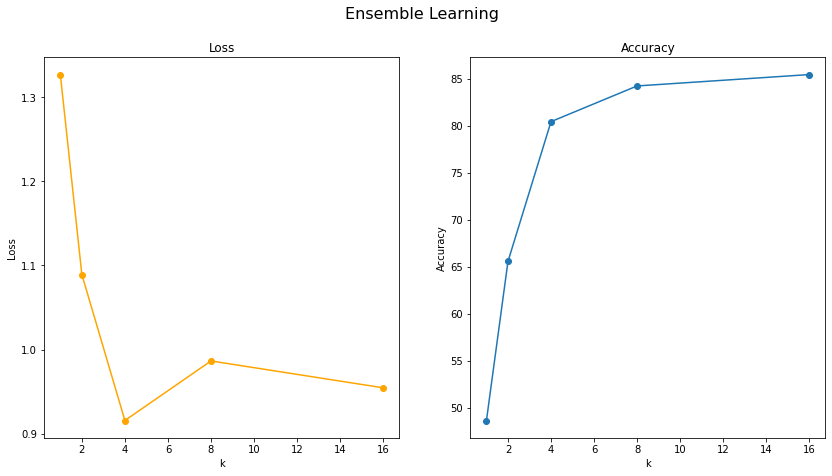

In [ ]:
# Graph
fig, (ax1, ax2)=plt.subplots(1,2,figsize=(14, 7))
fig.suptitle('Ensembled MLP', fontsize=16)

# plt.subplot(1, 2, 1)  # row 1, column 2, count 1
ax1.plot(k_list, k_loss, '-o', label='Loss', color='orange')
ax1.set_title('Loss')
ax1.set_xlabel('k')
ax1.set_ylabel('Loss')

ax2.plot(k_list, k_acc, '-o', label='Accuracy')
ax2.set_title('Accuracy')
ax2.set_xlabel('k')
ax2.set_ylabel('Accuracy')

plt.show()

### Question P2.b: Bagged networks  (15 Points)
Extend the above code to create a bag of `k` single hidden layer MLP models with each with `4` hidden units. Compare the performance of bags of different sizes `k`. In particular, compare the performance of `5` bages, with sizes $k = \{2, 4, 8, 16, 32\}$ respectively. To prevent additional sources of randomness, all the models within all the bags should be initialized to the same random seed. Train each model inside each bag for exactly `1` epoch. Report the final performance for each bag on the test set and compare it against each other. For the purpose of ensembling, you can take a majority vote of the model outputs. 

At a high level you need to perform the following tasks:
1. Create `k=5` bags of the training set of sizes $k = \{2, 4, 8, 16, 32\}$. (**5 points**)
2. Use the same extension to the train() function as in P2.a to train individual models in each bag: (**2.5 points**)
3. Use the same extension to the test() function as in P2.a to estimate the accuracy for each bag: (**2.5 points**)
4. Plot a graph with bag_size on the x-axis and bag performance on the y-axis. (**5 points**)

In [ ]:
train_dataset = datasets.MNIST('./data/MNIST',
                               train=True,
                               download=True,
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307, ), (0.3081, ))
                               ]))
bootstrap_sampler = torch.utils.data.RandomSampler(train_dataset,
                                                   replacement=True)
                                                   
bag_train_loader = torch.utils.data.DataLoader(train_dataset,
                                               sampler=bootstrap_sampler,
                                               batch_size=64,
                                               drop_last=True)


In [ ]:
# initialize some hyper-paramters
n_hidden = 4  # number of hidden units
learning_rate = 0.01
moment = 0.5
nepochs = 1

# build the actual model
model_ensemble = EnsembleMLP(2, input_size, n_hidden, output_size, verbose=False)
# model_ensemble.to(device)

# train the model for one epoch
for epoch in range(nepochs):
    print(f'======== TRAIN EPOCH {epoch} ========')
    model_ensemble.train(epoch, loader=bag_train_loader)
    torch.save(model_ensemble.state_dict(), './model_ensemble')

    print(f'\n======== TEST EPOCH {epoch} ========')
    model_ensemble.test()


======== TRAIN EPOCH 0 ========
Model 0 Epoch 0: [59904/60000 (100%)]	Loss: 1.376697
Model 1 Epoch 0: [59904/60000 (100%)]	Loss: 0.834718

======== TEST EPOCH 0 ========
Model 0 Test: Average loss: 1.3354, Accuracy: 4833.0/10000 (48%)
Model 1 Test: Average loss: 0.8489, Accuracy: 7201.0/10000 (72%)

k=2 Ensemble Average loss: 1.0921, Accuracy: 6606/10000 (66%)



In [ ]:
# k_list = [2, 4, 8, 16, 32]
bagged_k_list = [2, 4, 8, 16]
bagged_k_loss = []
bagged_k_acc = []
for k in bagged_k_list:
    print(f'======== k={k} ========')
    model_ensemble = EnsembleMLP(k,
                                 input_size,
                                 n_hidden,
                                 output_size,
                                 manual_seed=42,
                                 verbose=False)
    for epoch in range(nepochs):
        model_ensemble.train(epoch, loader=bag_train_loader)
    loss, acc = model_ensemble.test()
    bagged_k_loss.append(loss)
    bagged_k_acc.append(acc)

======== k=2 ========
Model 0 Epoch 0: [59904/60000 (100%)]	Loss: 0.861478
Model 1 Epoch 0: [59904/60000 (100%)]	Loss: 1.320757
Model 0 Test: Average loss: 0.9141, Accuracy: 7063.0/10000 (71%)
Model 1 Test: Average loss: 1.2888, Accuracy: 5527.0/10000 (55%)

k=2 Ensemble Average loss: 1.1014, Accuracy: 6146/10000 (61%)

======== k=4 ========
Model 0 Epoch 0: [59904/60000 (100%)]	Loss: 0.910722
Model 1 Epoch 0: [59904/60000 (100%)]	Loss: 1.256852
Model 2 Epoch 0: [59904/60000 (100%)]	Loss: 0.732422
Model 3 Epoch 0: [59904/60000 (100%)]	Loss: 0.877135
Model 0 Test: Average loss: 0.9309, Accuracy: 6921.0/10000 (69%)
Model 1 Test: Average loss: 1.2668, Accuracy: 5302.0/10000 (53%)
Model 2 Test: Average loss: 0.7408, Accuracy: 7712.0/10000 (77%)
Model 3 Test: Average loss: 0.9326, Accuracy: 6930.0/10000 (69%)

k=4 Ensemble Average loss: 0.9678, Accuracy: 7906/10000 (79%)

======== k=8 ========
Model 0 Epoch 0: [59904/60000 (100%)]	Loss: 0.803493
Model 1 Epoch 0: [59904/60000 (100%)]	Loss: 1

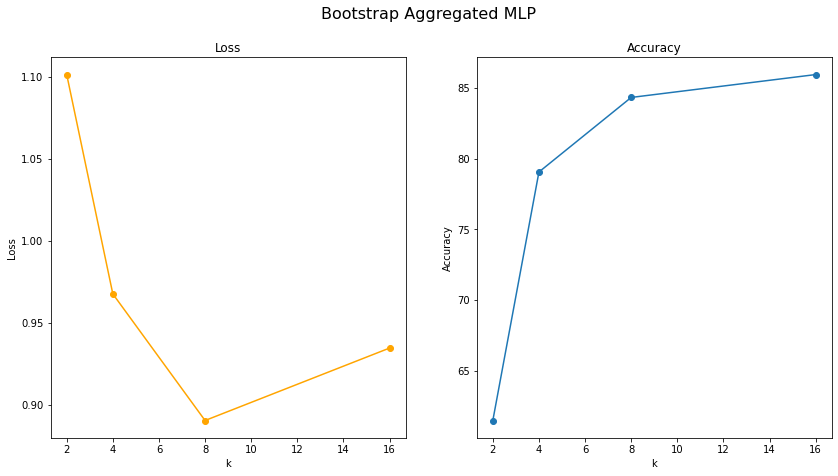

In [ ]:
# Graph
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
fig.suptitle('Bootstrap Aggregated MLP', fontsize=16)

# plt.subplot(1, 2, 1)  # row 1, column 2, count 1
ax1.plot(bagged_k_list, bagged_k_loss, '-o', label='Loss', color='orange')
ax1.set_title('Loss')
ax1.set_xlabel('k')
ax1.set_ylabel('Loss')

ax2.plot(bagged_k_list, bagged_k_acc, '-o', label='Accuracy')
ax2.set_title('Accuracy')
ax2.set_xlabel('k')
ax2.set_ylabel('Accuracy')

plt.show()